# Subject Data PreProcessing
* find subject data
* concatenate the inter-session data
* concatenate the intra-session data
* Clean and condense the data
* Create graphs

# TO DO
* Adapt the cleaning cell to also consider empty data points and mark them as noData in the DataFrame
    * Make sure that the timestamps are consistent!
    * Check for possible condition for noData points, e.g. unsufficient eye-openness - done by BitMask
    * Adapt script to rename all colliders to NoHouse that are no house (house list required)
    * adjust nan dataframes to also add sessions
* Condense data by replacing identical successive collider hits with (collidername, amount if hits)
* Account for lost data by interpolation! (Jasmins Script)
* Write gaze definition cell by assigning 21 consecutive hits to a gaze caused by an actual fixation. Mark >21 hits as noise 
* Create unweighted undirected graphs
    * Remove all noHouse hits 
    * Remove all self repetitions 
    * Check the exact procedure 


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [4]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [3]:
import os
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 


OG_DATA_PATH = './'
THEORETICAL_DATA_PATH = './Data Exploration/'
THEORETICAL_PROCESSED_DATA_PATH = './Results/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

### Extracting all subject IDs from the data folder

In [8]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1013 1019 1023 1079 1080 7357]


In [4]:
# custom subID
subIDs = [1023]

### Combine the data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [180]:
# --------- Preparation ---------

Session_save_bool = False # set to True if you want to save each individual session as csv
Exploration_save_bool = True # set to True if you want to save the complete exploration as csv
subcount = 0

# column name list for dataframe
col_names =  ['Session',
          'timeStampDataPointStart',
          'timeStampDataPointEnd',
          'hitObjectColliderName', 
          'ordinalOfHit',
          'BitMask',
          'hitPointOnObject.x',
          'hitPointOnObject.y',
          'hitPointOnObject.z',
          'hitObjectColliderBoundsCenter.x',
          'hitObjectColliderBoundsCenter.y',
          'hitObjectColliderBoundsCenter.z']


NoHit_dict = {'hitPointOnObject': {'x': 'NaN',
                                   'y': 'NaN',
                                   'z': 'NaN'},
              'hitObjectColliderName': 'NoHit',
              'hitObjectColliderBoundsCenter': {'x': 'NaN',
                                                'y': 'NaN',
                                                'z': 'NaN'},
              'ordinalOfHit': 'NaN',
              'Session': 'NaN',
              'timeStampDataPointStart': 'NaN',
              'timeStampDataPointEnd': 'NaN',
              'BitMask': 'NaN'
              }



# --------------------------- MAIN PART ---------------------------


# --------- first layer - subject loop ---------

for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject, ignoring OnQuit files
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_Expl_S_') and f.endswith("OnQuit.json") == False], 
                            key=str.lower) 
    
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    # Extract all SubIDs (only one), SessionNumbers, ET_SessionNumbers (and Timestamps)
    SubID, SessionNumbers, ET_SessionNumbers, UnixTimestamp1, UnixTimeStamp2 = map(list, zip(*folder_files))
    
    session_number = int(max(SessionNumbers)) # the maximum session number of the particular subject
    
    
# --------- second layer - exploration session loop ---------

    # loop over exploration sessions
    for EXP_session in range(session_number):
        # to avoid start at 0
        EXP_session +=1 

        # extract the exploration data
        subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject) + '_Expl_S_' + str(EXP_session)) 
                               and f.endswith("OnQuit.json") == False], key=str.lower)

        
        # hitpoint dataframe 
        complete_hitpoints_df = pd.DataFrame(columns = col_names)

        print("\tTotal Sessionfiles: "
              + str(len(subject_data))
              + " - Exploration Session "
              + str(EXP_session))
        
        s = 0 # session count
        
# --------- third layer - eye tracking session loop ---------

        # loop over separate eye tracking sessions
        for ET_session in subject_data:
            s+=1
            #print("\tSession " + str(s) + " started")

                # open the JSON file as dictionary
            with open(DATA_PATH + ET_session) as f:
                try:
                    subject_session = json.loads(f.read())
                except:
                    print("\tJSON file " + ET_session + " is not valid!")

            hitpoint_list = list() # create hitpoint list

            # start timestamp of the session 
            start_time = subject_session['trials'][0]['timeTrialMeasurementStarted']

            # amount of datapoints 
            Len_subses = len(subject_session['trials'][0]['dataPoints'])

            # for loop appending each data point rayCastHit Data
            # afterwards adding the timestamp to the dict 
            # passing if there is (1) no raycast hit and (2) if there is only one raycast hit
            for each in subject_session['trials'][0]['dataPoints']:

                # account for noHits 
                if each['rayCastHitsCombinedEyes'] == []:
                    hitpoint_list.append(NoHit_dict)
                else:
                    # append data point
                    hitpoint_list.append(each['rayCastHitsCombinedEyes'][0]) 
                    # add Session, timestamp and bitmask
                    idx = len(hitpoint_list)-1
                    hitpoint_list[idx]['Session'] = EXP_session
                    hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                    hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                    hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']


                try: 
                    # append data point of second raycast hit if it exists
                    hitpoint_list.append(each['rayCastHitsCombinedEyes'][1])
                    # add Session, timestamp and bitmask
                    idx = len(hitpoint_list)-1
                    hitpoint_list[idx]['Session'] = EXP_session
                    hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                    hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                    hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']

                except:
                    pass

            # normalize the hitpoint dictionary to get dataframe
            hitpoints_df = pd.json_normalize(hitpoint_list)
            
            print("\tEXP: " + str(EXP_session) + ", ET: " + str(s) + " normalized")
            
            complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)

            
        # --------- Saving each Session ---------
        
        # If you want to save each session separately, set 'Session_save_bool' to True
        if Session_save_bool == True:
            try:
                if len(subject_data) > 0:
                    complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH
                                                 + str(subject)
                                                 + "_CompleteSession"
                                                 + str(EXP_session)
                                                 + "_Hitpoints.csv")
                    print("\t"
                          + str(subject)
                          + " session "
                          + str(EXP_session)
                          + " saved ")
                else: 
                    print("\t"
                          + str(subject)
                          + " - Session "
                          + str(EXP_session)
                          + " is empty!")
            except:
                print("\tCould not save subject "
                      + str(subject)
                      + " session "
                      + str(EXP_session)
                      + "!")


        
        # fill the complete exploration dataframe with the separate session data (combining the sessions)
        complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)
        
    # --------- Saving the Exploration ---------
    
    # If you want to save the exploration file, set 'Exploration_save_bool' to True
    if Exploration_save_bool == True:
        # saving the complete exploration
        try:
            complete_exploration_df.to_csv(PROCESSED_DATA_PATH + str(subject) + "_CompleteExploration_Hitpoints.csv")
            print("\t" + str(subject) + " exploration saved")
        except:
            print("\tCould not save subject " + str(subject) + " exploration data!")
    

print('Done')

Subject 1023 started - 1/1
	Total Sessionfiles: 3 - Exploration Session 1
	EXP: 1, ET: 1 normalized
	EXP: 1, ET: 2 normalized
	EXP: 1, ET: 3 normalized
	Total Sessionfiles: 3 - Exploration Session 2
	EXP: 2, ET: 1 normalized
	EXP: 2, ET: 2 normalized
	EXP: 2, ET: 3 normalized
	Total Sessionfiles: 3 - Exploration Session 3
	EXP: 3, ET: 1 normalized
	EXP: 3, ET: 2 normalized
	EXP: 3, ET: 3 normalized
	Total Sessionfiles: 3 - Exploration Session 4
	EXP: 4, ET: 1 normalized
	EXP: 4, ET: 2 normalized
	EXP: 4, ET: 3 normalized
	Total Sessionfiles: 3 - Exploration Session 5
	EXP: 5, ET: 1 normalized
	EXP: 5, ET: 2 normalized
	EXP: 5, ET: 3 normalized
	1023 exploration saved
Done


In [195]:
complete_exploration_df

,Session,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,BitMask,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z
0,1,0.00198388,0.00843191,terrain_O.001,1,3,-58.6923,0.878483,58.7924,-165.373,-0.466505,-15.9875
1,1,0.00843191,0.00843191,terrain_O.001,1,3,-58.6923,0.878483,58.7924,-165.373,-0.466505,-15.9875
2,1,0.0119038,0.0148799,terrain_O.001,1,3,-58.6211,0.878169,58.7709,-165.373,-0.466505,-15.9875
3,1,0.0213273,0.0248003,terrain_O.001,1,3,-58.5471,0.875116,57.9094,-165.373,-0.466505,-15.9875
4,1,0.0327361,0.035712,terrain_O.001,1,3,-58.469,0.876383,58.2638,-165.373,-0.466505,-15.9875
...,...,...,...,...,...,...,...,...,...,...,...,...
125794,5,600.004,600.007,Building_147,2,3,-16.3937,0.959056,-20.0117,-10.4726,4.15142,-10.4927
125795,5,600.007,600.007,Building_145,1,3,11.2877,-0.279913,-53.9851,13.6172,4.3649,-44.695
125796,5,600.007,600.007,Building_147,2,3,-16.3937,0.959056,-20.0117,-10.4726,4.15142,-10.4927
125797,5,600.026,600.029,road_base_network.004,1,0,25.8953,-2.71592,-69.1855,39.2579,-4.4083,51.7689


In [201]:
# Some information about the data
bit_prop = np.sum(complete_exploration_df['BitMask'] != 3) / np.sum(complete_exploration_df['BitMask'] == 3)
noHit_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHit') / len(complete_exploration_df)


print("Portion of insufficient data quality (BitMask): " + str(bit_prop)) 
print("NoHits: " + str(noHit_prop))
print("Total missing data: " + str(bit_prop + noHit_prop))

Portion of insufficient data quality (BitMask): 0.033525154526677654
NoHits: 0.002814664821609178
Total missing data: 0.03633981934828683


### Condense the data and create gaze lists
* Do RLE on the colliderName column
* Filter out collider-counts < 21 
    * Based on Walter, 2021

In [74]:
# Preparation
subcount = 0

condense_col_names = ['Session', 
                      'ColliderName',
                      'Samples',
                      'Time']


# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_CompleteExploration_Hitpoints')], key=str.lower)
    
    # open the JSON file as dictionary
    with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
        try:
            data = pd.read_csv(f)
        except:
            print("\tCSV file " + subject_folder[0] + " is not valid!")
            
    data = data[:30000]

    condense_df = pd.DataFrame(index=range(len(data)), columns=condense_col_names)
    
    condense_df.Session = data.Session
    condense_df.ColliderName = data.hitObjectColliderName
    
    condense_df['Samples'] = data['hitObjectColliderName'].groupby((data['hitObjectColliderName'] != data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1



    

Subject 1023 started - 1/1


In [75]:
condense_df[:20]

,Session,ColliderName,Samples,Time
0,1.0,terrain_O.001,1,NaN
1,1.0,terrain_O.001,2,NaN
2,1.0,terrain_O.001,3,NaN
3,1.0,terrain_O.001,4,NaN
4,1.0,terrain_O.001,5,NaN
5,1.0,terrain_O.001,6,NaN
6,1.0,terrain_O.001,7,NaN
7,1.0,terrain_O.001,8,NaN
8,1.0,terrain_O.001,9,NaN
9,1.0,terrain_O.001,10,NaN


In [62]:
test = data.groupby('hitObjectColliderName').hitObjectColliderName.count()

test

hitObjectColliderName
Basketball_Court -3D           21
Bench_v1                        2
Bench_v1 (1)                   13
Body                         1077
Broadleaf_Mobile (5)            7
                             ... 
terrain_T.001                 153
terrain_V.001                 117
terrain_X.001                   4
terrain_Y.001                  10
traffic_light_single_tall      18
Name: hitObjectColliderName, Length: 312, dtype: int64

(array([2.8523e+04, 6.7400e+02, 3.4000e+02, 1.9500e+02, 1.2100e+02,
        5.0000e+01, 2.4000e+01, 2.4000e+01, 2.4000e+01, 2.5000e+01]),
 array([  1. ,  25.2,  49.4,  73.6,  97.8, 122. , 146.2, 170.4, 194.6,
        218.8, 243. ]),
 <BarContainer object of 10 artists>)

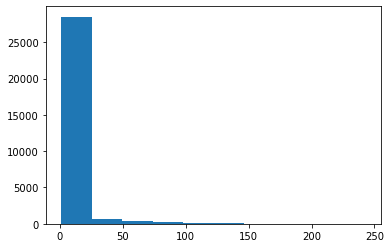

In [66]:
#condense_df['Samples'] = data['hitObjectColliderName'].groupby((data['hitObjectColliderName'] != data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1
plt.hist(condense_df.Samples)

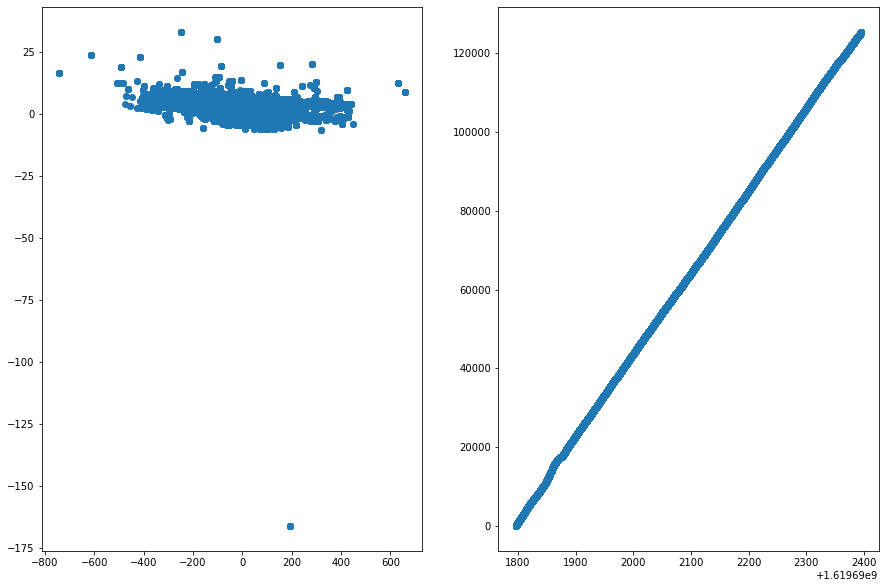

In [100]:
plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
plt.scatter(hitpoints_df["hitObjectColliderBoundsCenter.x"], hitpoints_df["hitObjectColliderBoundsCenter.y"])
plt.subplot(1,2,2)
plt.scatter(hitpoints_df["timeStampDataPointStart"], range(0,len(hitpoints_df)))